# Source Reconstruction


In [1]:
# Setup and imports
import os.path as op
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import mne_connectivity
import numpy as np
from IPython.display import clear_output
from mne_connectivity import envelope_correlation
from tqdm.auto import tqdm


In [5]:
# Helper functions
def creat_raw_from_epochs(epochs):
    data = np.hstack(epochs.get_data())
    info = mne.create_info(ch_names=epochs.ch_names,
                           ch_types='eeg',
                           sfreq=epochs.info['sfreq'])

    raw = mne.io.RawArray(data, info)
    raw.set_channel_types({'ECG': 'ecg', 'EOG1': 'eog', 'EOG2': 'eog'})
    return raw

def make_forward():
    # fsaverage files
    fs_dir = Path('data/fsaverage')

    # The files live in:
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = fs_dir / 'bem' / 'fsaverage-ico-4-src.fif' # use icosahedron4 with 6.2 mm source spacing
    src = mne.read_source_spaces(src)
    bem = fs_dir / 'bem' / 'fsaverage-5120-5120-5120-bem-sol.fif'
    
    path:Path = Path('data/clean_data')
    epochs_fname = path / 'sub-01_ses-01_task-baseline1_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)

    # create raw object
    raw = creat_raw_from_epochs(epochs)

    # insert channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # forward solution (the same across all subjects)
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=-1, verbose=False)
    del src, bem
    return fwd

def make_inverse_4baseline(subject: str,
                           fwd: mne.forward.forward.Forward,
                           path = Path('data/clean_data')):
    
    epochs_fname = path / f'{subject}_ses-01_task-baseline1_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)
    
    # create raw object
    raw = creat_raw_from_epochs(epochs)

    # insert channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    raw.set_eeg_reference('average', projection=True)
    
    # covariance matrix
    cov = mne.compute_raw_covariance(raw, method='auto', cv=5, n_jobs=-1)

    # inverse operator
    inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, verbose=False)
    
    return inv

def get_connectivity(subject: str,
                     task: str,
                     atlas_labels: list,
                     inv: mne.minimum_norm.inverse.InverseOperator,
                     path:Path = Path('data/clean_data')):
    # open data
    epochs_fname = path / f'{subject}_ses-01_task-{task}_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)

    stc = mne.minimum_norm.apply_inverse_epochs(epochs,
                                                inv,
                                                method='eLORETA',
                                                lambda2=1./9.,
                                                verbose=False)
    
    
    label_ts = mne.extract_label_time_course(stc,
                                             atlas_labels,
                                             inv['src'],
                                             return_generator=False,
                                             verbose=False)
    
    conn_obj = envelope_correlation(label_ts, orthogonalize='pairwise')
    conn = conn_obj.combine()
    conn = conn.get_data(output='dense')[..., 0]
    
    return conn

# Forward and Inverse Model

In [8]:
# we will use Yeo2011 atlas
atlas_labels = mne.read_labels_from_annot('fsaverage',
                                          'Yeo2011_17Networks_N1000',
                                          subjects_dir='data/')

# forward solution (same across all subjects)
fwd = make_forward()

for subject_path in sorted(Path('data/clean_data').glob('*.fif')):

    subject, task = re.search('(.*)_ses.*_task-(.*)_proc.*', subject_path.stem).groups()
    
    output_path = Path(f'data/connectivities/{subject}_task-{task}_conn-corr.npz')
    
    # if output_path.exists():
    #     continue
        
    print('>>>>>>>>', subject, task)
    if task == 'baseline1':
        inv = make_inverse_4baseline(subject, fwd)
        
    elif 'induction' in task or task == 'baseline2':
        continue
    
    else: 
        conn = get_connectivity(subject, task, atlas_labels, inv)
        np.savez(output_path, conn=conn)

    clear_output()

>>>>>>>> sub-52 induction1
>>>>>>>> sub-52 induction4


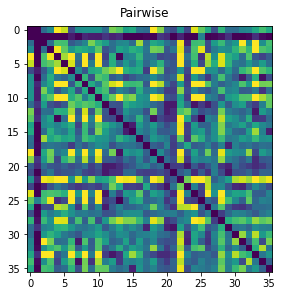

In [14]:
# visualization
def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
    fig.suptitle(title)


plot_corr(conn, 'Pairwise')